In [1]:
import json
import math
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple, OrderedDict

In [2]:
sys.path.insert(0, 'src/lib')

In [3]:
from utils import car_models
from utils.camera import create_camera_matrix, euler_angles_to_rotation_matrix, euler_angles_to_quaternions, proj_point, calc_bbox
from utils.image import affine_transform, get_affine_transform, draw_msra_gaussian, draw_umich_gaussian, gaussian_radius
from utils.kaggle_cars_utils import pad_img_sides, parse_annot_str

In [4]:
INPUT_PATH = 'data/pku-autonomous-driving'
MODEL_DIR = os.path.join(INPUT_PATH, 'car_models_json')

In [5]:
def load_car_models(model_dir=MODEL_DIR):
    """Load all the car models
    """
    car_models_all = OrderedDict([])
    print('loading %d car models' % len(car_models.models))
    for model in car_models.models:
        car_model = '%s/%s.json' % (model_dir, model.name)
        with open(car_model) as json_file:
            car = json.load(json_file)
        for key in ['vertices', 'faces']:
            car[key] = np.array(car[key])
        # fix the inconsistency between obj and pkl
        car['vertices'][:, [0, 1]] *= -1
        car_models_all[model.name] = car 
    return car_models_all  

In [6]:
def find_car_poses(img_id, df, models_3d, calib):
    cond = df['ImageId'] == img_id
    cars = df.loc[cond, 'PredictionString'].values[0]
    cars = parse_annot_str(str(cars))
    for car in cars:
        car_name = car_models.car_id2name[car['car_id']].name
        car_model = models_3d[car_name]
        bbox = calc_bbox(car_model['vertices'], car['rotation'], 
                         car['location'], calib)
        car['bbox'] = np.array(bbox)
    return cars


def imread(path, img_dir=INPUT_PATH):
    path = os.path.join(img_dir, path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image


def imshow(img, boxes=None, figsize=(15,8)):
    plt.figure(figsize=figsize)
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            plt.gca().add_patch(rect)
    plt.imshow(img)


def add_blend_img(back, fore, trans=0.7, white_theme=False):
    if white_theme:
        fore = 255 - fore
    if fore.shape[0] != back.shape[0] or fore.shape[0] != back.shape[1]:
        fore = cv2.resize(fore, (back.shape[1], back.shape[0]))
    if len(fore.shape) == 2:
        fore = fore.reshape(fore.shape[0], fore.shape[1], 1)
    out = (back * (1. - trans) + fore * trans)
    out[out > 255] = 255
    out[out < 0] = 0
    return out.astype(np.uint8).copy()

In [7]:
def rand_affine(c, s, cf=0.1, sf=0.4):
    s = s * np.clip(np.random.randn()*sf + 1, 1 - sf, 1 + sf)
    c[0] += img.shape[1] * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
    c[1] += img.shape[0] * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
    return c, s

In [8]:
def stringify(p):
    return ', '.join(p.astype(str).tolist())


def project_to_image(pts_3d, P):
    # pts_3d: n x 3
    # P: 3 x 4
    # return: n x 2
    pts_3d_homo = np.concatenate(
        [pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], axis=1)
    pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]
    return pts_2d

In [9]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))

In [10]:
models = load_car_models()

loading 79 car models


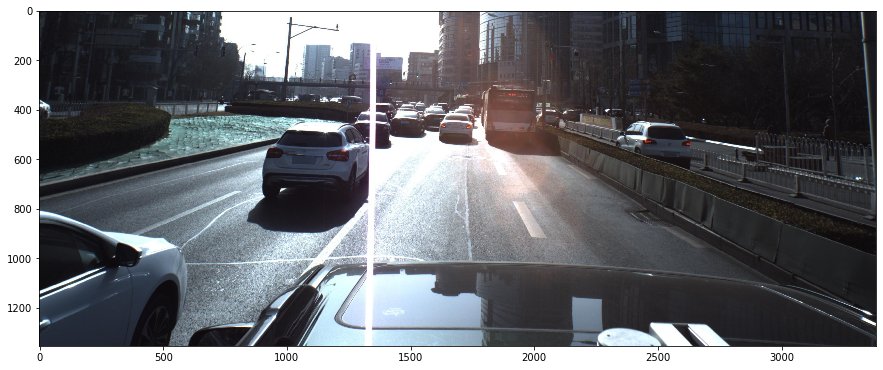

In [11]:
img_id = 'ID_0289b0bc8'
img_bottom_half = True
img = imread(f'train_images/{img_id}.jpg')

if img_bottom_half:
    h_mid = img.shape[0] // 2
    img = img[h_mid:]
    
imshow(img)

In [12]:
height, width = img.shape[0], img.shape[1]

inp_w, inp_h = 1280, 512
down_ratio = 4
pad_w_pct = 0.3

out_w, out_h = inp_w // down_ratio, inp_h // down_ratio
out_w, out_h

c = np.array([width / 2., height / 2.])
s = np.array([width, height], dtype=np.int32)

(width, height), (inp_w, inp_h), (out_w, out_h)

((3384, 1355), (1280, 512), (320, 128))

In [13]:
num_classes = 1
max_objs = 50

calib = create_camera_matrix()
anns = find_car_poses(img_id, df, models, calib)

num_objs = min(len(anns), max_objs)
num_objs

12

In [14]:
anns[0]

{'car_id': 19,
 'rotation': array([ 0.149891 ,  0.0447806, -3.10181  ]),
 'location': array([-3.22167,  3.42203, 13.8885 ]),
 'bbox': array([ 901, 1791, 1343, 2104], dtype=int32)}

In [15]:
draw_gaussian = draw_umich_gaussian
aug = False

trans_input = get_affine_transform(c, s, 0, [inp_w, inp_h])
trans_output = get_affine_transform(c, s, 0, [out_w, out_h])

inp = cv2.warpAffine(img, trans_input, (inp_w, inp_h), flags=cv2.INTER_LINEAR)
inp = inp.transpose(2, 0, 1)
hm = np.zeros((num_classes, out_h, out_w), dtype=np.float32)

if pad_w_pct > 0:
    inp = pad_img_sides(inp, pad_w_pct)
    hm = pad_img_sides(hm, pad_w_pct)

bboxes = []

for k in range(num_objs):
    ann = anns[k]
    ct = proj_point(ann['location'], calib)
    bbox = np.array(ann['bbox'])
    if pad_w_pct > 0:
        offset = int(width * pad_w_pct / 2)
        ct[0] += offset
        bbox[[0, 2]] += offset
    if img_bottom_half:
        ct[1] -= height
        bbox[[1, 3]] -= height
    ct = affine_transform(ct, trans_output)
    ct[0] = np.clip(ct[0], 0, hm.shape[2] - 1)
    ct[1] = np.clip(ct[1], 0, hm.shape[1] - 1)
    ct_int = ct.astype(np.int32)
    # if flipped:
    #   bbox[[0, 2]] = width - bbox[[2, 0]] - 1
    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox[[0, 2]] = np.clip(bbox[[0, 2]], 0, hm.shape[2] - 1)
    bbox[[1, 3]] = np.clip(bbox[[1, 3]], 0, hm.shape[1] - 1)
    h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    if h > 0 and w > 0:
        radius = gaussian_radius((h, w))
        radius = max(0, int(radius))
        draw_gaussian(hm[0], ct, radius)
        bboxes.append(bbox)

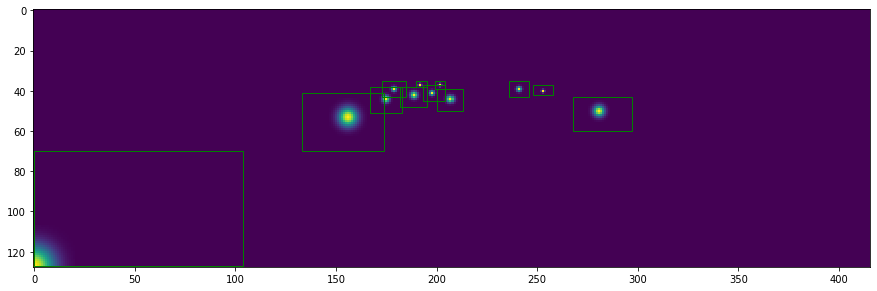

In [16]:
imshow(hm[0], boxes=bboxes)

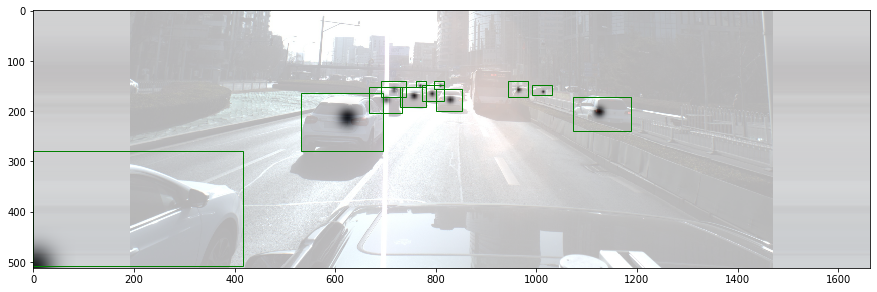

In [17]:
inp0 = inp.transpose(1, 2, 0)
bboxes0 = [bb * down_ratio for bb in bboxes]
blend = add_blend_img(inp0, hm[0] * 255, white_theme=True)
imshow(blend, boxes=bboxes0)